### unzip dataset

In [1]:
import zipfile
import os

zip_path = "nutrition5k_dataset.zip"  
extract_path = "nutrition5k" 

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# === Step 3: List extracted files/folders ===
for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}")
    for file in files:
        print(f"{file}")


Directory: nutrition5k
Directory: nutrition5k/__MACOSX
._nutrition5k_dataset
Directory: nutrition5k/__MACOSX/nutrition5k_dataset
._.DS_Store
._dish_ids
._scripts
._metadata
._imagery
Directory: nutrition5k/__MACOSX/nutrition5k_dataset/metadata
._dish_metadata_cafe1.csv
._dish_metadata_cafe2.csv
Directory: nutrition5k/__MACOSX/nutrition5k_dataset/imagery
._.DS_Store
._side_angles
._realsense_overhead
Directory: nutrition5k/__MACOSX/nutrition5k_dataset/imagery/realsense_overhead
._.DS_Store
._dish_1566934401
._dish_1562617370
._dish_1561492182
._dish_1565118067
._dish_1562172643
._dish_1558637698
._dish_1562872914
._dish_1558719401
._dish_1559157919
._dish_1565987015
._dish_1558723926
._dish_1561661347
._dish_1565118729
._dish_1561661479
._dish_1567110783
._dish_1572021506
._dish_1562010315
._dish_1562774159
._dish_1566332085
._dish_1566922978
._dish_1565725095
._dish_1563309315
._dish_1558549150
._dish_1563465805
._dish_1561580659
._dish_1563308323
._dish_1561493975
._dish_1558461792
._

In [4]:
import pandas as pd
import json

dish_ids = set([
    "dish_1558549150", "dish_1562872396", "dish_1565640601", "dish_1563308323",
"dish_1564589025", "dish_1550775363", "dish_1550711688", "dish_1562872914", "dish_1551222068",
"dish_1563309315", "dish_1551139415", "dish_1558723926", "dish_1565118729", "dish_1551232627",
"dish_1558719401", "dish_1551488572", "dish_1567110783", "dish_1551124322", "dish_1561493975",
"dish_1558461792", "dish_1561580659", "dish_1551374189", "dish_1566332085", "dish_1566922978",
"dish_1562172643", "dish_1561148481", "dish_1566934401", "dish_1561661347", "dish_1563378029",
"dish_1572021506", "dish_1562010315", "dish_1565118067", "dish_1561492182", "dish_1551233345",
"dish_1551566208", "dish_1562617370", "dish_1551222363", "dish_1559157919", "dish_1563477659",
"dish_1551381555", "dish_1562774159", "dish_1558637698", "dish_1564432238", "dish_1567613057",
"dish_1566328894", "dish_1561661479", "dish_1565725095", "dish_1565987015", "dish_1550770866",
"dish_1563465805"
])

def parse_row(parts):
    try:
        fixed = parts[:6]
        ingredients = []
        i = 6
        while i + 6 < len(parts):
            ingr = {
                "ingredient_id": parts[i],
                "ingredient_name": parts[i+1],
                "ingredient_weight_g": float(parts[i+2]),
                "ingredient_calories_kcal": float(parts[i+3]),
                "ingredient_fat_g": float(parts[i+4]),
                "ingredient_protein_g": float(parts[i+5]),
                "ingredient_carbs_g": float(parts[i+6])
            }
            ingredients.append(ingr)
            i += 7
        return {
            "dish_id": fixed[0],
            "total_mass_g": float(fixed[1]),
            "total_calories_kcal": float(fixed[2]),
            "total_fat_g": float(fixed[3]),
            "total_protein_g": float(fixed[4]),
            "total_carbohydrates_g": float(fixed[5]),
            "ingredients": ingredients
        }
    except Exception as e:
        print(f"Error parsing row for dish {parts[0]}: {e}")
        return None

# === Step 3: Read and parse both CSVs ===
all_dishes = []

for path in ["nutrition5k/nutrition5k_dataset/metadata/dish_metadata_cafe1.csv",
             "nutrition5k/nutrition5k_dataset/metadata/dish_metadata_cafe2.csv"]:
    
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(",")
            if parts[0] in dish_ids:
                parsed = parse_row(parts)
                if parsed:
                    all_dishes.append(parsed)

# === Step 4: Save output ===
with open("ground_truth_macros.json", "w") as out_f:
    json.dump(all_dishes, out_f, indent=2)

print(f"✅ Saved {len(all_dishes)} matched dish entries to 'ground_truth_macros.json'")

✅ Saved 50 matched dish entries to 'ground_truth_macros.json'


Found 36 valid image entries.
Missing 14 images: ['dish_1550775363', 'dish_1563378029', 'dish_1551566208', 'dish_1551124322', 'dish_1550770866']...


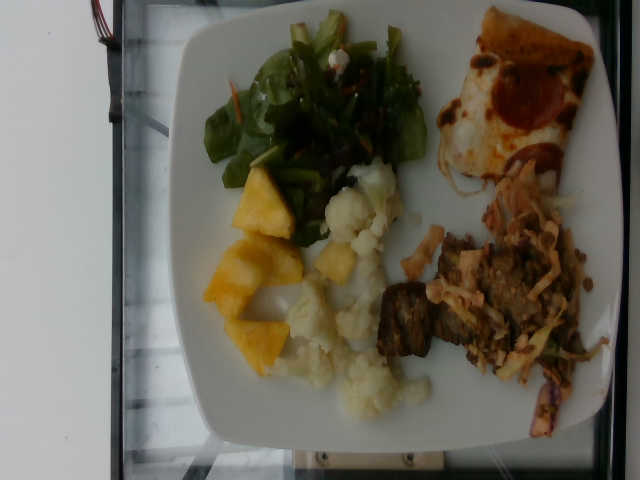

In [8]:
import os
import json
from PIL import Image
from IPython.display import display

with open("ground_truth_macros.json", "r") as f:
    ground_truth_data = json.load(f)

image_entries = []
missing = []

for item in ground_truth_data:
    dish_id = item["dish_id"]
    img_path = f"nutrition5k/nutrition5k_dataset/imagery/realsense_overhead/{dish_id}/rgb.png"
    
    if os.path.exists(img_path):
        image_entries.append({
            "dish_id": dish_id,
            "image_path": img_path,
            "ground_truth": item
        })
    else:
        missing.append(dish_id)

print(f"Found {len(image_entries)} valid image entries.")
if missing:
    print(f"Missing {len(missing)} images: {missing[:5]}...")

if image_entries:
    from IPython.display import display
    sample_img = Image.open(image_entries[0]["image_path"])
    display(sample_img)
else:
    print("⚠️ No images found. Please check that your folder structure is correct:")
    print("Expected path: realsense_overhead/{dish_id}/rgb.jpg")


In [10]:
import json

with open("llava_input_data.json", "w") as f:
    json.dump(image_entries, f, indent=2)

print("✅ Saved 36 image entries to 'llava_input_data.json'")


✅ Saved 36 image entries to 'llava_input_data.json'


In [11]:
import requests
import base64
import json
from PIL import Image
from io import BytesIO

from pathlib import Path

# Load the 36 valid image entries
with open("llava_input_data.json", "r") as f:
    image_entries = json.load(f)

prompt = """
This is an image of a plated dish. Identify all visible food items and estimate their quantity. 
For each food item, provide:
- Name
- Quantity
- Unit macros (calories, protein, carbs, fat)
- Total macros (based on quantity)

Respond in valid JSON format like:
[
  {
    "food": "name",
    "quantity": 2,
    "unit_macros": { "calories": 100, "protein": 5, "carbs": 10, "fat": 2 },
    "total_macros": { "calories": 200, "protein": 10, "carbs": 20, "fat": 4 }
  }
]
"""

results = []

for i, entry in enumerate(image_entries):
    dish_id = entry["dish_id"]
    image_path = entry["image_path"]
    
    # Read and encode image
    with open(image_path, "rb") as img_f:
        image_bytes = img_f.read()
        b64_image = base64.b64encode(image_bytes).decode("utf-8")

    # Send to Ollama API
    response = requests.post("http://localhost:11434/api/generate", json={
        "model": "llava:7b-v1.6",
        "prompt": prompt,
        "images": [b64_image],
        "stream": False
    })

    # Parse response
    try:
        res_json = response.json()
        text_output = res_json.get("response", "")
        results.append({
            "dish_id": dish_id,
            "image_path": image_path,
            "llava_output": text_output,
            "ground_truth": entry["ground_truth"]
        })
        print(f"✅ {i+1}/{len(image_entries)}: {dish_id} done")
    except Exception as e:
        print(f"❌ Failed on {dish_id}: {e}")

# Save raw predictions
with open("llava_predictions_raw.json", "w") as f:
    json.dump(results, f, indent=2)


✅ 1/36: dish_1564432238 done
✅ 2/36: dish_1567613057 done
✅ 3/36: dish_1558723926 done
✅ 4/36: dish_1561661347 done
✅ 5/36: dish_1566922978 done
✅ 6/36: dish_1558549150 done
✅ 7/36: dish_1565640601 done
✅ 8/36: dish_1562872914 done
✅ 9/36: dish_1558637698 done
✅ 10/36: dish_1561580659 done
✅ 11/36: dish_1563308323 done
✅ 12/36: dish_1562010315 done
✅ 13/36: dish_1565725095 done
✅ 14/36: dish_1564589025 done
✅ 15/36: dish_1565118067 done
✅ 16/36: dish_1565118729 done
✅ 17/36: dish_1562774159 done
✅ 18/36: dish_1566328894 done
✅ 19/36: dish_1563309315 done
✅ 20/36: dish_1563477659 done
✅ 21/36: dish_1561148481 done
✅ 22/36: dish_1566332085 done
✅ 23/36: dish_1562617370 done
✅ 24/36: dish_1567110783 done
✅ 25/36: dish_1563465805 done
✅ 26/36: dish_1565987015 done
✅ 27/36: dish_1562172643 done
✅ 28/36: dish_1561492182 done
✅ 29/36: dish_1566934401 done
✅ 30/36: dish_1559157919 done
✅ 31/36: dish_1561661479 done
✅ 32/36: dish_1562872396 done
✅ 33/36: dish_1561493975 done
✅ 34/36: dish_15587

In [13]:
for item in data[:3]:
    print("\n=== Dish:", item["dish_id"])
    print(item["llava_output"])


=== Dish: dish_1564432238
 ```json
[
  {
    "food": "Pizza slice",
    "quantity": 1,
    "unit_macros": { "calories": 300, "protein": 15, "carbs": 45, "fat": 15 },
    "total_macros": { "calories": 300, "protein": 15, "carbs": 45, "fat": 15 }
  },
  {
    "food": "Salad",
    "quantity": 1,
    "unit_macros": { "calories": 70, "protein": 3, "carbs": 8, "fat": 2 },
    "total_macros": { "calories": 70, "protein": 3, "carbs": 8, "fat": 2 }
  },
  {
    "food": "Steamed veggies",
    "quantity": 1/4 cup,
    "unit_macros": { "calories": 50, "protein": 2, "carbs": 8, "fat": 1 },
    "total_macros": { "calories": 50, "protein": 2, "carbs": 8, "fat": 1 }
  },
  {
    "food": "Mashed potatoes",
    "quantity": 1/4 cup,
    "unit_macros": { "calories": 60, "protein": 2, "carbs": 12, "fat": 2 },
    "total_macros": { "calories": 60, "protein": 2, "carbs": 12, "fat": 2 }
  },
  {
    "food": "Meat (likely beef)",
    "quantity": 1/4 cup,
    "unit_macros": { "calories": 100, "protein": 5, "ca

In [16]:
import json
import numpy as np
import ast
import re

with open("llava_predictions_raw.json", "r") as f:
    data = json.load(f)

all_results = []

def safe_sum(pred_items):
    try:
        start = pred_items.find("[")
        end = pred_items.rfind("]") + 1
        if start == -1 or end == -1:
            return None
        json_str = pred_items[start:end]

        # Step 2: Fix unquoted quantity fields like 1/4 cup
        json_str = re.sub(r'"quantity"\s*:\s*([\d/]+(?:\s*\w+)?)', r'"quantity": "\1"', json_str)

        # Step 3: Parse cleaned JSON
        items = json.loads(json_str)

        # Step 4: Sum total_macros
        total = {"calories": 0, "protein": 0, "carbs": 0, "fat": 0}
        for food in items:
            macros = food.get("total_macros", {})
            total["calories"] += float(macros.get("calories", 0))
            total["protein"] += float(macros.get("protein", 0))
            total["carbs"] += float(macros.get("carbs", 0))
            total["fat"] += float(macros.get("fat", 0))
        return total

    except Exception as e:
        print(f"⚠️ Final JSON parsing failed: {e}")
        return None


    total = {"calories": 0, "protein": 0, "carbs": 0, "fat": 0}
    for food in items:
        try:
            macros = food["total_macros"]
            total["calories"] += float(macros["calories"])
            total["protein"] += float(macros["protein"])
            total["carbs"] += float(macros["carbs"])
            total["fat"] += float(macros["fat"])
        except:
            continue
    return total

for item in data:
    gt = item["ground_truth"]
    pred_text = item["llava_output"]

    pred_macros = safe_sum(pred_text)
    if pred_macros is None:
        continue  # skip if LLaVA output is malformed

    error = {
        "dish_id": item["dish_id"],
        "mae_calories": abs(gt["total_calories_kcal"] - pred_macros["calories"]),
        "mae_protein": abs(gt["total_protein_g"] - pred_macros["protein"]),
        "mae_carbs": abs(gt["total_carbohydrates_g"] - pred_macros["carbs"]),
        "mae_fat": abs(gt["total_fat_g"] - pred_macros["fat"]),
        "gt": gt,
        "pred": pred_macros
    }
    all_results.append(error)

# MAE
mae_calories = np.mean([e["mae_calories"] for e in all_results])
mae_protein = np.mean([e["mae_protein"] for e in all_results])
mae_carbs = np.mean([e["mae_carbs"] for e in all_results])
mae_fat = np.mean([e["mae_fat"] for e in all_results])

print("📊 Macro MAE Results (LLaVA 1.6 vs Ground Truth):")
print(f"Calories MAE: {mae_calories:.2f}")
print(f"Protein  MAE: {mae_protein:.2f} g")
print(f"Carbs    MAE: {mae_carbs:.2f} g")
print(f"Fat      MAE: {mae_fat:.2f} g")


df_results = pd.DataFrame(all_results)
df_results.to_csv("llava_vs_gt_macro_errors.csv", index=False)


📊 Macro MAE Results (LLaVA 1.6 vs Ground Truth):
Calories MAE: 553.56
Protein  MAE: 26.09 g
Carbs    MAE: 65.38 g
Fat      MAE: 20.84 g


In [17]:
def compute_accuracy(truth, pred, tolerance=0.15):
    return abs(pred - truth) / truth <= tolerance if truth != 0 else False


In [20]:
import json
import pandas as pd
import re

# === Load raw prediction file ===
with open("llava_predictions_raw.json", "r") as f:
    raw_data = json.load(f)

# === Parse and collect clean rows ===
rows = []

def parse_llava_output(output):
    try:
        # Extract JSON array between first [ and last ]
        start = output.find("[")
        end = output.rfind("]") + 1
        json_str = output[start:end]

        # Fix malformed quantity fields
        json_str = re.sub(r'"quantity"\s*:\s*([\d/]+(?:\s*\w+)?)', r'"quantity": "\1"', json_str)

        # Load JSON
        items = json.loads(json_str)

        # Sum total_macros
        total = {"calories": 0, "protein": 0, "carbs": 0, "fat": 0}
        for food in items:
            macros = food.get("total_macros", {})
            total["calories"] += float(macros.get("calories", 0))
            total["protein"] += float(macros.get("protein", 0))
            total["carbs"] += float(macros.get("carbs", 0))
            total["fat"] += float(macros.get("fat", 0))
        return total
    except:
        return None

# === Extract usable rows ===
for entry in raw_data:
    gt = entry["ground_truth"]
    parsed = parse_llava_output(entry["llava_output"])
    if parsed:
        rows.append({
            "dish_id": entry["dish_id"],
            "gt_calories": gt["total_calories_kcal"],
            "gt_protein": gt["total_protein_g"],
            "gt_carbs": gt["total_carbohydrates_g"],
            "gt_fat": gt["total_fat_g"],
            "pred_calories": parsed["calories"],
            "pred_protein": parsed["protein"],
            "pred_carbs": parsed["carbs"],
            "pred_fat": parsed["fat"],
        })

# === Convert to DataFrame ===
df = pd.DataFrame(rows)
print(f"✅ Loaded {len(df)} valid predictions.")

# === Define accuracy function ===
def compute_accuracy(truth, pred, tolerance=0.15):
    try:
        return abs(pred - truth) / truth <= tolerance if truth != 0 else False
    except:
        return False

# === Apply accuracy per macro ===
df["acc_calories"] = df.apply(lambda x: compute_accuracy(x["gt_calories"], x["pred_calories"]), axis=1)
df["acc_protein"]  = df.apply(lambda x: compute_accuracy(x["gt_protein"], x["pred_protein"]), axis=1)
df["acc_carbs"]    = df.apply(lambda x: compute_accuracy(x["gt_carbs"], x["pred_carbs"]), axis=1)
df["acc_fat"]      = df.apply(lambda x: compute_accuracy(x["gt_fat"], x["pred_fat"]), axis=1)

# === Print accuracy results ===
print("📊 Accuracy (within ±15% of ground truth):")
print(f"Calories Accuracy : {df['acc_calories'].mean() * 100:.2f}%")
print(f"Protein  Accuracy : {df['acc_protein'].mean() * 100:.2f}%")
print(f"Carbs    Accuracy : {df['acc_carbs'].mean() * 100:.2f}%")
print(f"Fat      Accuracy : {df['acc_fat'].mean() * 100:.2f}%")




✅ Loaded 36 valid predictions.
📊 Accuracy (within ±15% of ground truth):
Calories Accuracy : 2.78%
Protein  Accuracy : 5.56%
Carbs    Accuracy : 11.11%
Fat      Accuracy : 11.11%
